# ELG7186 - Fall 2022 - Assignment 3
## Due: <strong>Wednesday Nov. 23<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


### Importing the libraries

In [79]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
# Math
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
# libraries for appling the operations on image
from skimage import io
import cv2
# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam

### Functions

In [44]:
def PlotConfusionMatrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title(f"The confusion matrix of {title}")
    plt.show()
    print(f'The accuracy score of {title}: {accuracy_score(y_true,y_pred)*100}%')

### Importing the dataset

In [4]:
Train_Dir = "/content/drive/MyDrive/tmp/training"
Test_Dir = "/content/drive/MyDrive/tmp/testing"
Train_classes = os.listdir((Train_Dir))
Test_classes = os.listdir((Test_Dir))

In [5]:
dataSetTrain = []
labelsTrain = []
size = 64
for label in Train_classes:
    fullPath = Train_Dir + '/' + label
    print(label)
    nameImgs = [nameImg for nameImg in os.listdir(fullPath) if nameImg.endswith(('jpg', 'png'))]
    for nameImg in nameImgs:
        img = cv2.imread(fullPath + '/' +nameImg)
        img = cv2.resize(img, (size, size))
        #print(img)
        dataSetTrain.append(img)
        labelsTrain.append(label)

3
2
6
4
1


In [6]:
dataSetTest = []
labelsTest = []
for label in Test_classes:
    fullPath = Test_Dir + '/' + label
    print(label)
    nameImgs = [nameImg for nameImg in os.listdir(fullPath) if nameImg.endswith(('jpg', 'png'))]
    for nameImg in nameImgs:
        img = cv2.imread(fullPath + '/' +nameImg)
        img = cv2.resize(img, (size, size))
        #print(img)
        dataSetTest.append(img)
        labelsTest.append(label)

2
4
3
1
6


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
trainSet = np.array(dataSetTrain)
X_test = np.array(dataSetTest)
# convert string to number
trainLabels = np.array(labelsTrain).astype('int')
y_test = np.array(labelsTest).astype('int')
print(f'the shape of trainSet: {trainSet.shape}')
print(f'the shape of trainLabels: {trainLabels.shape}')
print(f'the shape of testSet: {X_test.shape}')
print(f'the shape of y_test: {y_test.shape}')

the shape of trainSet: (900, 64, 64, 3)
the shape of trainLabels: (900,)
the shape of testSet: (100, 64, 64, 3)
the shape of y_test: (100,)


In [10]:
np.unique(trainLabels)

array([1, 2, 3, 4, 6])

##### plot a grid for five samples of each class (5)

In [11]:
def draw5SampleEachClass(numClasses,numSamples, dataset=trainSet, label=trainLabels):
    numRows = numClasses
    numColums = numSamples
    f, axarr = plt.subplots(numRows,numColums, figsize=(10, 10))
    initrow = 0
    for nClass in np.unique(trainLabels):
        initNumCol = 0
        lst = np.where(label==nClass)[0][:numSamples]
        for i in lst:
            axarr[initrow,initNumCol].imshow(dataset[i])
            axarr[initrow, initNumCol].axis('off')
            axarr[initrow, 0].set_title(f'class {nClass}')
            initNumCol += 1
        initrow += 1

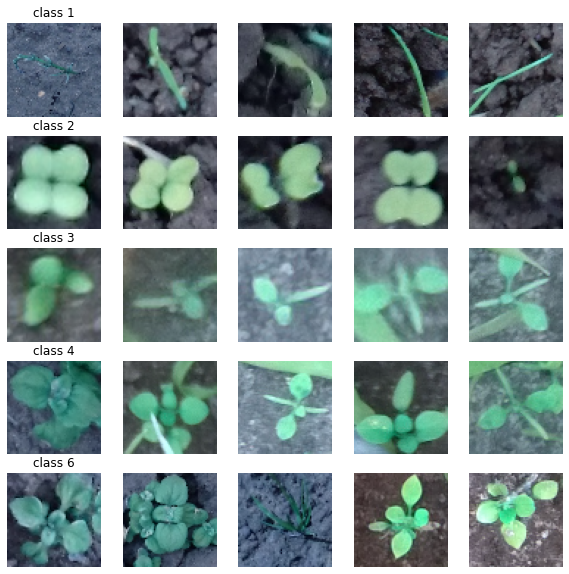

In [12]:
# each row is 5 sample for each class (5)
draw5SampleEachClass(len(Train_classes),5,trainSet,trainLabels)

##### split 180 images per class into training and validation

In [13]:
X_train, X_val, y_train, y_val = train_test_split(trainSet, trainLabels, test_size=0.20, random_state=42,shuffle=True,stratify=trainLabels)

In [14]:
print(f'the shape of X_train: {X_train.shape}')
print(f'the shape of y_train: {y_train.shape}')
print(f'the shape of X_val: {X_val.shape}')
print(f'the shape of y_val: {y_val.shape}')
print(f'the shape of X_test: {X_test.shape}')
print(f'the shape of y_test: {y_test.shape}')

the shape of X_train: (720, 64, 64, 3)
the shape of y_train: (720,)
the shape of X_val: (180, 64, 64, 3)
the shape of y_val: (180,)
the shape of X_test: (100, 64, 64, 3)
the shape of y_test: (100,)


In [15]:
np.random.seed = 42

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [16]:
from collections import Counter
Counter(y_train)

Counter({6: 144, 2: 144, 4: 144, 3: 144, 1: 144})

In [17]:
le = LabelEncoder()
y_train_ = le.fit_transform(y_train)
y_val_ = le.transform(y_val)
#y_train_ = le.inverse_transform(y_train_)

In [18]:
Counter(y_train_)

Counter({4: 144, 1: 144, 3: 144, 2: 144, 0: 144})

In [105]:
# Write your code here

ModelVGG16_base = VGG16(include_top=False, weights="imagenet" ,input_shape=X_train.shape[1:])
for layer in ModelVGG16_base.layers:
    if ('block1' in layer.name) or ('block2' in layer.name):
        layer.trainable = False
conv = ModelVGG16_base.layers[6].output
# layer 1
conv = Conv2D(128,(3, 3), activation='relu') (conv)
conv = MaxPooling2D((2, 2)) (conv)
# layer 2
conv = Conv2D(128,(3, 3), activation='relu') (conv)
conv = MaxPooling2D((2, 2))(conv)
# Flatten
conv = Flatten() (conv)
# ouput layer
output = Dense(5, activation='softmax') (conv)
preModelVGG16 = Model(inputs=ModelVGG16_base.input, outputs=output)
preModelVGG16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [106]:
preModelVGG16.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [107]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=0.0001)
historyPreModelVGG16 = preModelVGG16.fit(x = X_train, y = y_train_, validation_data=(X_val, y_val_), epochs=100,batch_size=64, verbose=2)

Epoch 1/100
12/12 - 1s - loss: 1726.4510 - accuracy: 0.2181 - val_loss: 189.2747 - val_accuracy: 0.1944 - 868ms/epoch - 72ms/step
Epoch 2/100
12/12 - 0s - loss: 93.3451 - accuracy: 0.2403 - val_loss: 54.6215 - val_accuracy: 0.2667 - 251ms/epoch - 21ms/step
Epoch 3/100
12/12 - 0s - loss: 39.5126 - accuracy: 0.2542 - val_loss: 32.4068 - val_accuracy: 0.2611 - 249ms/epoch - 21ms/step
Epoch 4/100
12/12 - 0s - loss: 24.0471 - accuracy: 0.2986 - val_loss: 25.0335 - val_accuracy: 0.2444 - 254ms/epoch - 21ms/step
Epoch 5/100
12/12 - 0s - loss: 17.8876 - accuracy: 0.3250 - val_loss: 20.2836 - val_accuracy: 0.2611 - 243ms/epoch - 20ms/step
Epoch 6/100
12/12 - 0s - loss: 14.0946 - accuracy: 0.3347 - val_loss: 18.5818 - val_accuracy: 0.2278 - 222ms/epoch - 18ms/step
Epoch 7/100
12/12 - 0s - loss: 10.5999 - accuracy: 0.3389 - val_loss: 16.7151 - val_accuracy: 0.1833 - 224ms/epoch - 19ms/step
Epoch 8/100
12/12 - 0s - loss: 8.2366 - accuracy: 0.4181 - val_loss: 15.8975 - val_accuracy: 0.2167 - 219ms/

In [108]:
preModelVGG16.save('preModelVGG16.h5')

##### Plot a loss curve for training and validation data

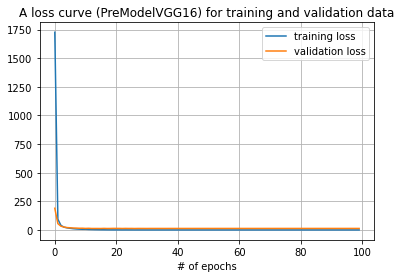

In [113]:
plt.title("A loss curve (PreModelVGG16) for training and validation data")
#np.log10()
plt.plot(historyPreModelVGG16.history['loss'])
plt.plot(historyPreModelVGG16.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel("# of epochs")
plt.grid()

##### Plot an accuracy curve for training and validation data

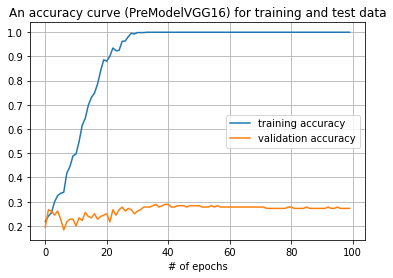

In [114]:
plt.title("An accuracy curve (PreModelVGG16) for training and test data")
plt.plot(historyPreModelVGG16.history['accuracy'])
plt.plot(historyPreModelVGG16.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel("# of epochs")
plt.grid()

##### Plot confusion matrix of PreModelVGG16 on the training including validation and testing data sets.

23/23 [==============================] - 0s 8ms/step


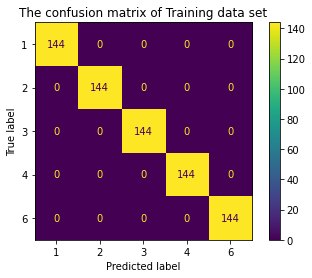

The accuracy score of Training data set: 100.0%
6/6 [==============================] - 0s 8ms/step


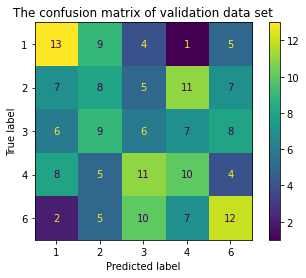

The accuracy score of validation data set: 27.22222222222222%
4/4 [==============================] - 0s 8ms/step


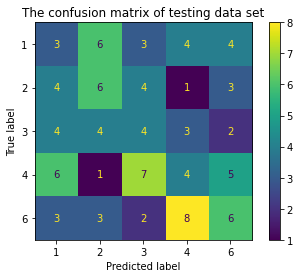

The accuracy score of testing data set: 23.0%


In [112]:
#########--------Prediction of train data set----------#########################
predTrain = np.argmax(preModelVGG16.predict(X_train), axis=1)
predTrain_final =  le.inverse_transform(predTrain)
PlotConfusionMatrix(predTrain_final, y_train, np.unique(y_train), "Training data set")
#########--------Prediction of train data set----------#########################
predval = np.argmax(preModelVGG16.predict(X_val), axis=1)
predval_final =  le.inverse_transform(predval)
PlotConfusionMatrix(predval_final, y_val, np.unique(y_val), "validation data set")
#########--------Prediction of test data set----------#########################
predTest = np.argmax(preModelVGG16.predict(X_test), axis=1)
predTest_final =  le.inverse_transform(predTest)
PlotConfusionMatrix(predTest_final, y_test, np.unique(y_test), "testing data set")

## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [86]:
# Write your code here
ModelVGG16_Regss_base = VGG16(include_top=False, weights="imagenet" ,input_shape=X_train.shape[1:],classifier_activation="linear")
for layer in ModelVGG16_Regss_base.layers:
    if ('block1' in layer.name) or ('block2' in layer.name):
        layer.trainable = False
conv_Regss = ModelVGG16_Regss_base.layers[6].output
# layer 1
conv_Regss = Conv2D(128,(3, 3), activation='tanh') (conv_Regss)
conv_Regss = MaxPooling2D((2, 2)) (conv_Regss)
# # layer 2
conv_Regss = Conv2D(256,(3, 3), activation='relu') (conv_Regss)
conv_Regss = MaxPooling2D((2, 2))(conv_Regss)
# # Flatten
conv_Regss = Flatten() (conv_Regss)
# layer
conv_Regss = Dense(512, activation = "relu")(conv_Regss)
conv_Regss = Dense(512, activation = "relu")(conv_Regss)
# ouput layer ==>  'accuracy', 'mean_absolute_error', 'mean_squared_error'
output_Regss = Dense(1) (conv_Regss)
preModelVGG16_Regss = Model(inputs=ModelVGG16_Regss_base.input, outputs=output_Regss)
preModelVGG16_Regss.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'accuracy'])
preModelVGG16_Regss.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [87]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=0.0001)
historyPreModelVGG16_Regss = preModelVGG16_Regss.fit(x = X_train/255, y = y_train.astype('float'), validation_data=(X_val/255, y_val.astype('float')), epochs=100,batch_size=128, verbose=2)

Epoch 1/100
6/6 - 1s - loss: 14.6834 - mean_squared_error: 14.6834 - accuracy: 0.1681 - val_loss: 3.0361 - val_mean_squared_error: 3.0361 - val_accuracy: 0.2000 - 1s/epoch - 175ms/step
Epoch 2/100
6/6 - 0s - loss: 3.5059 - mean_squared_error: 3.5059 - accuracy: 0.2000 - val_loss: 4.0214 - val_mean_squared_error: 4.0214 - val_accuracy: 0.2000 - 264ms/epoch - 44ms/step
Epoch 3/100
6/6 - 0s - loss: 3.4351 - mean_squared_error: 3.4351 - accuracy: 0.2000 - val_loss: 2.9486 - val_mean_squared_error: 2.9486 - val_accuracy: 0.2000 - 231ms/epoch - 39ms/step
Epoch 4/100
6/6 - 0s - loss: 3.0541 - mean_squared_error: 3.0541 - accuracy: 0.2000 - val_loss: 3.0802 - val_mean_squared_error: 3.0802 - val_accuracy: 0.2000 - 230ms/epoch - 38ms/step
Epoch 5/100
6/6 - 0s - loss: 2.9500 - mean_squared_error: 2.9500 - accuracy: 0.2000 - val_loss: 3.1423 - val_mean_squared_error: 3.1423 - val_accuracy: 0.2000 - 254ms/epoch - 42ms/step
Epoch 6/100
6/6 - 0s - loss: 2.9905 - mean_squared_error: 2.9905 - accuracy

In [88]:
preModelVGG16_Regss.save("preModelVGG16_Regss.h5")

##### Plot a loss curve for training and validation data

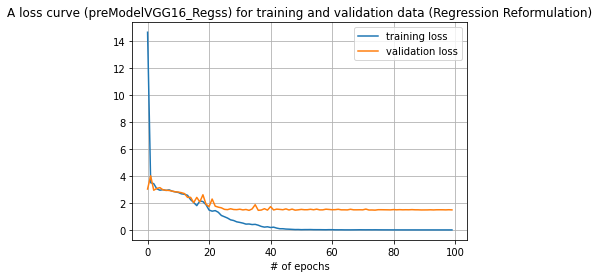

In [115]:
plt.title("A loss curve (preModelVGG16_Regss) for training and validation data (Regression Reformulation)")
#np.log10()
plt.plot(historyPreModelVGG16_Regss.history['loss'])
plt.plot(historyPreModelVGG16_Regss.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel("# of epochs")
plt.grid()

#### Plot an accuracy curve for training and validation data

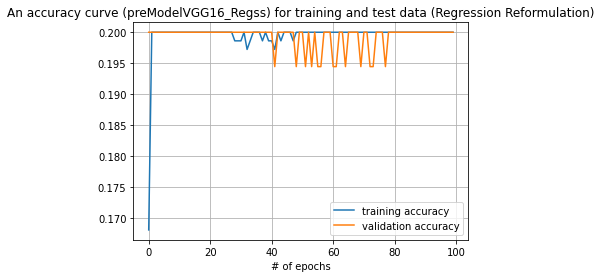

In [116]:
plt.title("An accuracy curve (preModelVGG16_Regss) for training and test data (Regression Reformulation)")
plt.plot(historyPreModelVGG16_Regss.history['accuracy'])
plt.plot(historyPreModelVGG16_Regss.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel("# of epochs")
plt.grid()

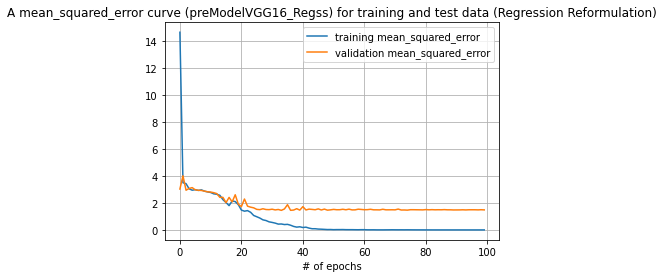

In [117]:
plt.title("A mean_squared_error curve (preModelVGG16_Regss) for training and test data (Regression Reformulation)")
plt.plot(historyPreModelVGG16_Regss.history['mean_squared_error'])
plt.plot(historyPreModelVGG16_Regss.history['val_mean_squared_error'])
plt.legend(['training mean_squared_error', 'validation mean_squared_error'])
plt.xlabel("# of epochs")
plt.grid()

##### Plot confusion matrix of PreModelVGG16 on the training including validation and testing data sets. (Regression Reformulation)

23/23 [==============================] - 0s 9ms/step


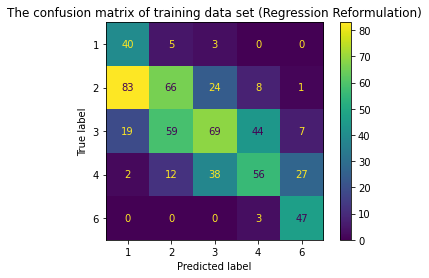

The accuracy score of training data set (Regression Reformulation): 38.611111111111114%
6/6 [==============================] - 0s 7ms/step


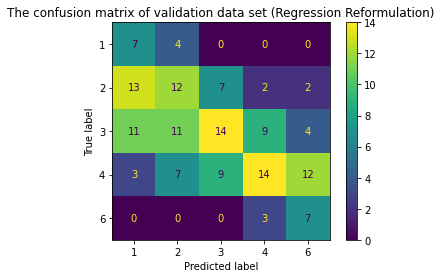

The accuracy score of validation data set (Regression Reformulation): 30.0%
4/4 [==============================] - 0s 7ms/step


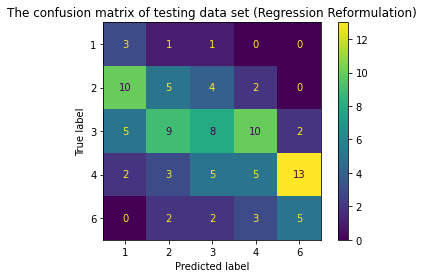

The accuracy score of testing data set (Regression Reformulation): 26.0%


In [93]:
#########--------Prediction of train data set----------#########################
predTrainRess = np.round(preModelVGG16_Regss.predict(X_train))
predTrainRess[predTrainRess<1] = 1
predTrainRess[predTrainRess>5] = 6
predTrainRess = np.array([4 if i > 4 and i < 5 else i for i in predTrainRess.flatten()])
PlotConfusionMatrix(predTrainRess, y_train, np.unique(y_train), "training data set (Regression Reformulation)")
#########--------Prediction of train data set----------#########################
predvalRess = np.round(preModelVGG16_Regss.predict(X_val))
predvalRess[predvalRess<1] = 1
predvalRess[predvalRess>5] = 6
predvalRess = np.array([4 if i > 4 and i < 5 else i for i in predvalRess.flatten()])
PlotConfusionMatrix(predvalRess, y_val, np.unique(y_val), "validation data set (Regression Reformulation)")
#########--------Prediction of test data set----------#########################
predTestRess = preModelVGG16_Regss.predict(X_test)
predTestRess[predTestRess<1] = 1
predTestRess[predTestRess>5] = 6
predTestRess = np.array([4 if i > 4 and i < 5 else i for i in predTestRess.flatten()])
predTestRess = np.round(predTestRess).astype('int').flatten()
PlotConfusionMatrix(predTestRess, y_test, np.unique(y_test), "testing data set (Regression Reformulation)")

### **Discuss the models from Parts 1a and 1b**

#### When applying a classification network to a pre-trained VGG-16 model that had been trained by plants' dataset (on Brightspace), its figure curve of accuracy showed that it had overfitting because the training accuracy score on each epoch was 100% and the validation and testing accuracy scores were 27.2% and 23%, respectively (**1a**).And when applying regression reformulation to it, it had underfitting because its figure curve of accuracy on each epoch showed that training and validation were very bad(**1b**).

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

In [51]:
# Write your code here
VGG16_R_base = VGG16(include_top=False, weights="imagenet" ,input_shape=X_train.shape[1:])
for layer in VGG16_R_base.layers:
    if ('block1' in layer.name) or ('block2' in layer.name):
        layer.trainable = False
conv_R = VGG16_R_base.layers[6].output
# layer 1
conv_R = Conv2D(128,(3, 3), activation='relu') (conv_R)
conv_R = MaxPooling2D((2, 2)) (conv_R)
conv_R = Dropout(0.5) (conv_R)
conv_R = BatchNormalization() (conv_R)
# layer 2
conv_R = Conv2D(128,(3, 3), activation='relu') (conv_R)
conv_R = MaxPooling2D((2, 2))(conv_R)
conv_R = Dropout(0.5) (conv_R)
conv_R = BatchNormalization() (conv_R)
# Flatten
conv_R = Flatten() (conv_R)
# ouput layer
output_R = Dense(5, activation='softmax') (conv_R)
preVGG16_R = Model(inputs=VGG16_R_base.input, outputs=output_R)
preVGG16_R.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
preVGG16_R.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [52]:
HistpreVGG16_R = preVGG16_R.fit(x = X_train, y = y_train_, validation_data=(X_val, y_val_), epochs=100,batch_size=64, verbose=2)

Epoch 1/100
12/12 - 1s - loss: 2.1918 - accuracy: 0.2208 - val_loss: 7.0623 - val_accuracy: 0.2111 - 1s/epoch - 87ms/step
Epoch 2/100
12/12 - 0s - loss: 1.7313 - accuracy: 0.3500 - val_loss: 3.4110 - val_accuracy: 0.2278 - 244ms/epoch - 20ms/step
Epoch 3/100
12/12 - 0s - loss: 1.5550 - accuracy: 0.3764 - val_loss: 2.8510 - val_accuracy: 0.2444 - 247ms/epoch - 21ms/step
Epoch 4/100
12/12 - 0s - loss: 1.4206 - accuracy: 0.4528 - val_loss: 2.5668 - val_accuracy: 0.3444 - 209ms/epoch - 17ms/step
Epoch 5/100
12/12 - 0s - loss: 1.3400 - accuracy: 0.4944 - val_loss: 1.7237 - val_accuracy: 0.4389 - 208ms/epoch - 17ms/step
Epoch 6/100
12/12 - 0s - loss: 1.2166 - accuracy: 0.5250 - val_loss: 1.5695 - val_accuracy: 0.4778 - 213ms/epoch - 18ms/step
Epoch 7/100
12/12 - 0s - loss: 1.1225 - accuracy: 0.5556 - val_loss: 1.2745 - val_accuracy: 0.5278 - 212ms/epoch - 18ms/step
Epoch 8/100
12/12 - 0s - loss: 1.0332 - accuracy: 0.6139 - val_loss: 1.3240 - val_accuracy: 0.5444 - 212ms/epoch - 18ms/step
Epo

In [53]:
preVGG16_R.save("preVGG16_R.h5")

###### Plot a loss curve for training and validation data  after applying Regularization

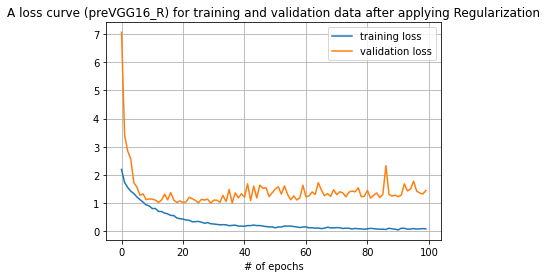

In [118]:
plt.title("A loss curve (preVGG16_R) for training and validation data after applying Regularization")
#np.log10()
plt.plot(HistpreVGG16_R.history['loss'])
plt.plot(HistpreVGG16_R.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel("# of epochs")
plt.grid()

##### Plot an accuracy curve for training and validation data

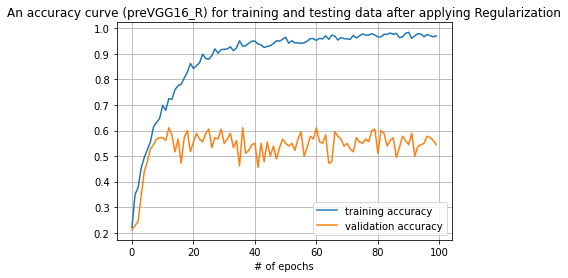

In [119]:
plt.title("An accuracy curve (preVGG16_R) for training and testing data after applying Regularization")
plt.plot(HistpreVGG16_R.history['accuracy'])
plt.plot(HistpreVGG16_R.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel("# of epochs")
plt.grid()

##### Plot confusion matrix of PreModelVGG16 on the training including validation and testing data sets.

23/23 [==============================] - 1s 16ms/step


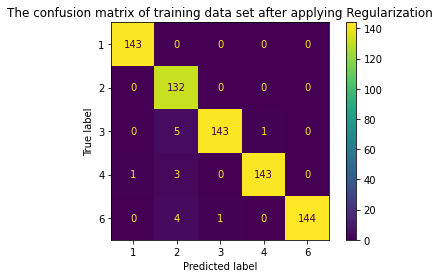

The accuracy score of training data set after applying Regularization: 97.91666666666666%
6/6 [==============================] - 0s 57ms/step


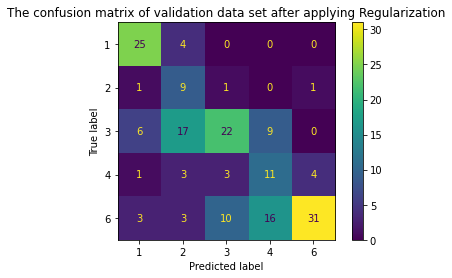

The accuracy score of validation data set after applying Regularization: 54.44444444444444%
4/4 [==============================] - 0s 52ms/step


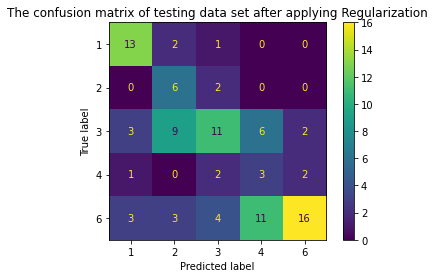

The accuracy score of testing data set after applying Regularization: 49.0%


In [56]:
#########--------Prediction of train data set----------#########################
predTrain_R = np.argmax(preVGG16_R.predict(X_train), axis=1)
predTrain_R_final =  le.inverse_transform(predTrain_R)
PlotConfusionMatrix(predTrain_R_final, y_train, np.unique(y_train), "training data set after applying Regularization")
#########--------Prediction of train data set----------#########################
predval_R = np.argmax(preVGG16_R.predict(X_val), axis=1)
predval_R_final =  le.inverse_transform(predval_R)
PlotConfusionMatrix(predval_R_final, y_val, np.unique(y_val), "validation data set after applying Regularization")
#########--------Prediction of test data set----------#########################
predTest_R = np.argmax(preVGG16_R.predict(X_test), axis=1)
predTest_R_final =  le.inverse_transform(predTest_R)
PlotConfusionMatrix(predTest_R_final, y_test, np.unique(y_test), "testing data set after applying Regularization")

#### Using data augmentation on data set

In [57]:
from keras_preprocessing.image import ImageDataGenerator
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    brightness_range=[0.5,2.0],
    featurewise_center =True,
    featurewise_std_normalization = True)

In [71]:
batches = training_datagen.flow(X_train,y_train_, batch_size=X_train.shape[0], shuffle=True).next()
X_train_after_augm = batches[0]
y_train_after_augm = batches[1]
X_train_after_augm = np.concatenate([X_train_after_augm, X_train])
y_train_after_augm = np.concatenate([y_train_after_augm, y_train_])
print(f'the shape of X_train after applying data augmentation: {X_train_after_augm.shape}')
print(f'the shape of y_train after applying data augmentation: {y_train_after_augm.shape}')

the shape of X_train after applying data augmentation: (1440, 64, 64, 3)
the shape of y_train after applying data augmentation: (1440,)


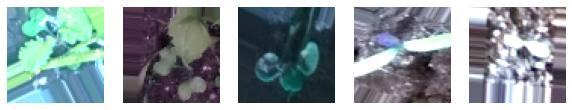

In [59]:
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,7))

# generate batch of images
for i in range(5):
    # convert to unsigned integers
    image = X_train_after_augm[i]
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

In [73]:
preModelVGG16_after_augm = preVGG16_R
historyPreModelVGG16_after_augm = preModelVGG16_after_augm.fit(x = X_train_after_augm, y = y_train_after_augm, validation_data=(X_val, y_val_), epochs=100,batch_size=64, verbose=2)

Epoch 1/100
23/23 - 0s - loss: 0.6943 - accuracy: 0.7021 - val_loss: 1.3815 - val_accuracy: 0.5722 - 489ms/epoch - 21ms/step
Epoch 2/100
23/23 - 0s - loss: 0.7325 - accuracy: 0.6861 - val_loss: 1.3923 - val_accuracy: 0.5556 - 404ms/epoch - 18ms/step
Epoch 3/100
23/23 - 0s - loss: 0.7690 - accuracy: 0.6736 - val_loss: 1.6312 - val_accuracy: 0.5500 - 424ms/epoch - 18ms/step
Epoch 4/100
23/23 - 0s - loss: 0.7199 - accuracy: 0.6812 - val_loss: 1.3369 - val_accuracy: 0.5778 - 397ms/epoch - 17ms/step
Epoch 5/100
23/23 - 0s - loss: 0.7260 - accuracy: 0.6924 - val_loss: 1.4778 - val_accuracy: 0.5500 - 392ms/epoch - 17ms/step
Epoch 6/100
23/23 - 0s - loss: 0.7194 - accuracy: 0.6771 - val_loss: 1.3528 - val_accuracy: 0.5444 - 401ms/epoch - 17ms/step
Epoch 7/100
23/23 - 0s - loss: 0.7077 - accuracy: 0.6938 - val_loss: 1.2183 - val_accuracy: 0.5833 - 394ms/epoch - 17ms/step
Epoch 8/100
23/23 - 0s - loss: 0.7024 - accuracy: 0.6896 - val_loss: 1.4907 - val_accuracy: 0.5333 - 433ms/epoch - 19ms/step


In [74]:
preModelVGG16_after_augm.save('preModelVGG16_after_augm.h5')

#### Plot a loss curve for training and validation data after applying data augmentation

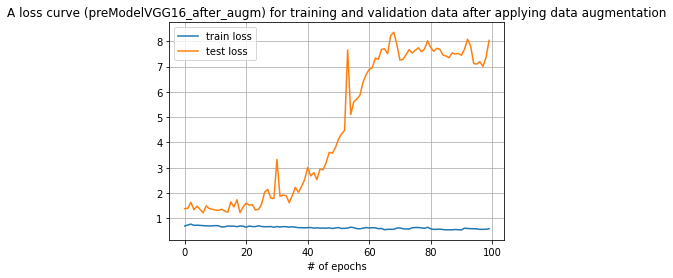

In [75]:
plt.title("A loss curve (preModelVGG16_after_augm) for training and validation data after applying data augmentation")
#np.log10()
plt.plot(historyPreModelVGG16_after_augm.history['loss'])
plt.plot(historyPreModelVGG16_after_augm.history['val_loss'])
plt.legend(['train loss', 'test loss'])
plt.xlabel("# of epochs")
plt.grid()

#### Plot an accuracy curve for training and validation data after applying data augmentation

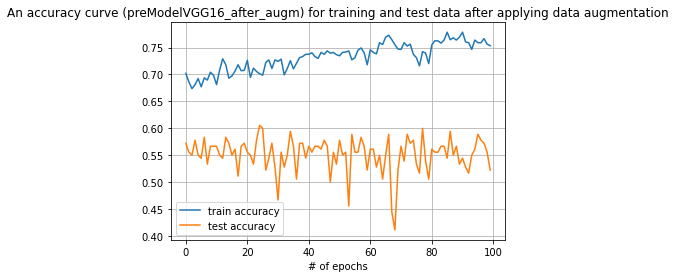

In [76]:
plt.title("An accuracy curve (preModelVGG16_after_augm) for training and test data after applying data augmentation")
plt.plot(historyPreModelVGG16_after_augm.history['accuracy'])
plt.plot(historyPreModelVGG16_after_augm.history['val_accuracy'])
plt.legend(['train accuracy', 'test accuracy'])
plt.xlabel("# of epochs")
plt.grid()

#### Plot confusion matrix of PreModelVGG16 on the training including validation and testing data sets after applying data augmentation

23/23 [==============================] - 0s 7ms/step


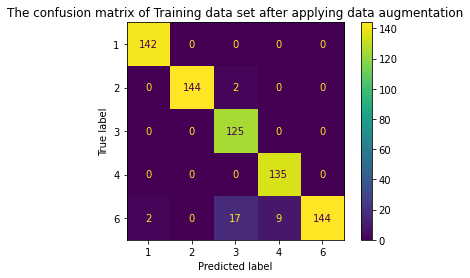

The accuracy score of Training data set after applying data augmentation: 95.83333333333334%
6/6 [==============================] - 0s 8ms/step


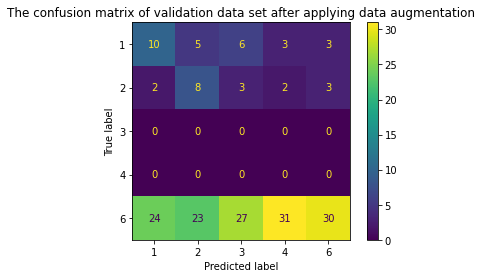

The accuracy score of validation data set after applying data augmentation: 26.666666666666668%
4/4 [==============================] - 0s 7ms/step


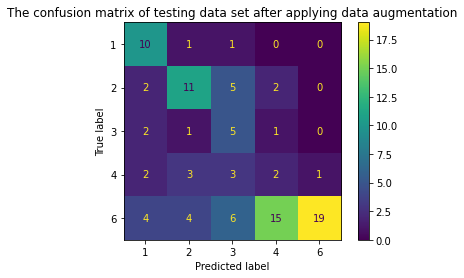

The accuracy score of testing data set after applying data augmentation: 47.0%


In [77]:
#########--------Prediction of train data set----------#########################
predTrain_afaugm = np.argmax(preModelVGG16_after_augm.predict(X_train), axis=1)
predTrain_final_afaugm =  le.inverse_transform(predTrain_afaugm)
PlotConfusionMatrix(predTrain_final_afaugm, y_train, np.unique(y_train), "Training data set after applying data augmentation")
#########--------Prediction of train data set----------#########################
predval_afaugm = np.argmax(preModelVGG16.predict(X_val), axis=1)
predval_final_afaugm =  le.inverse_transform(predval_afaugm)
PlotConfusionMatrix(predval_final_afaugm, y_val, np.unique(y_val), "validation data set after applying data augmentation")
#########--------Prediction of test data set----------#########################
predTest_afaugm = np.argmax(preModelVGG16_after_augm.predict(X_test), axis=1)
predTest_final_afaugm =  le.inverse_transform(predTest_afaugm)
PlotConfusionMatrix(predTest_final_afaugm, y_test, np.unique(y_test), "testing data set after applying data augmentation")

#### **Discuss on Regularisation and Data Augmentation**

**When regularisation (dropout and batch normalisation) was applied to the pretrain model (preVGG16_R), it overfit again because training accuracy was very high and validation accuracy was very low on its curve figure, requiring more layers through regularization. And when using data augmentation on it, its curve figure showed that it had underfitting on each epoch because the accuracy of training and validation were very low, so the dataset will need more images for each class and more layers.**

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.